# Human Activity Recognistion of Accelerometer Data from WISDM using CNN

Raw Accelorometer Data Obtained from [WISDM]((https://www.cis.fordham.edu/wisdm/dataset.php))

Hamza Ahmed

----

In [2]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Convolution2D, MaxPool2D
from tensorflow.keras.optimizers import Adam


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import scipy.stats as stats

### Load the DataSet

In [4]:


# define the columns: 
cols = ['user', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']

# Read the text file as a CSV 
df = pd.read_csv('../data/WISDM_ar_v1.1_raw.txt', sep=',', on_bad_lines='skip', names=cols)

# drop null values
df = df.dropna()

df['z-axis'] = df['z-axis'].str.rstrip(';')

## Exploratory Data Analysis

**Class Count**

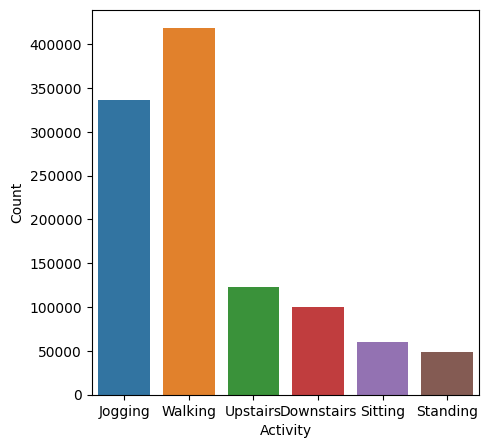

In [5]:
plt.figure(figsize=(5,5))
sns.countplot(x='activity', data=df, hue='activity')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.show()

In [6]:
df['activity'].value_counts()

activity
Walking       418393
Jogging       336445
Upstairs      122869
Downstairs    100425
Sitting        59939
Standing       48394
Name: count, dtype: int64

**Observation** : Large Class Imbalance. <br>
This can lead to overfitting and skewing towards class with a greater count such as Jogging and Walking

**Signal Variation per Activity**

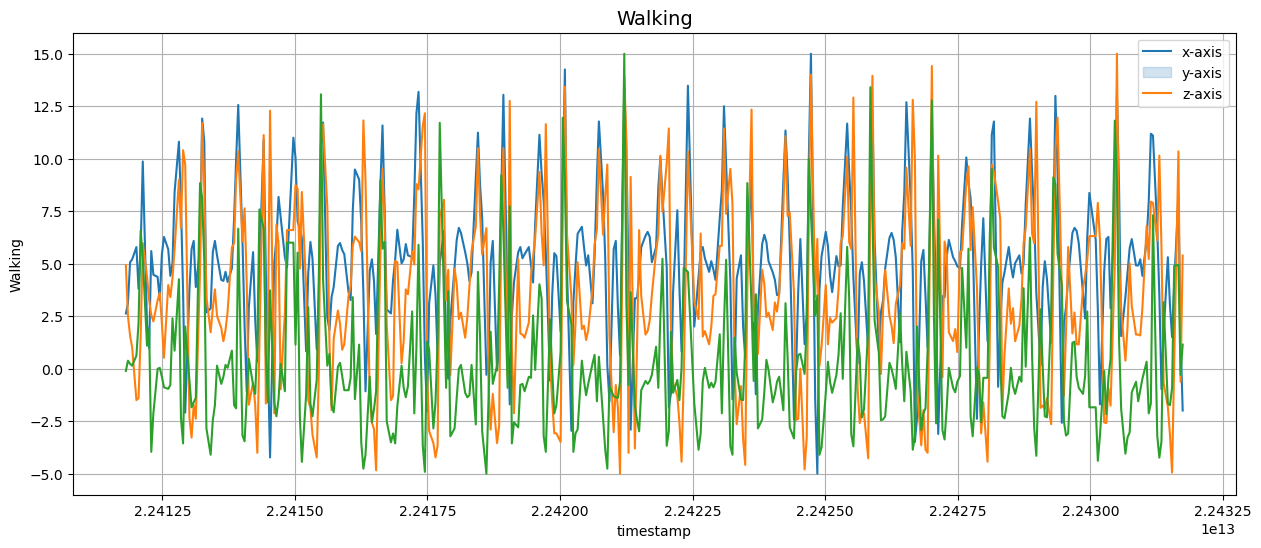

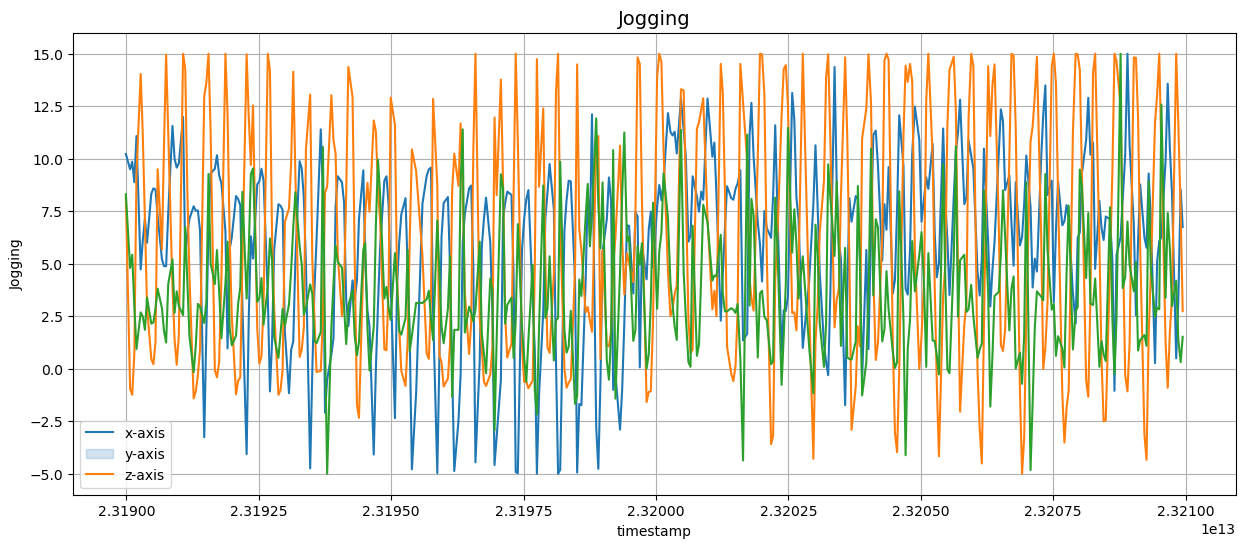

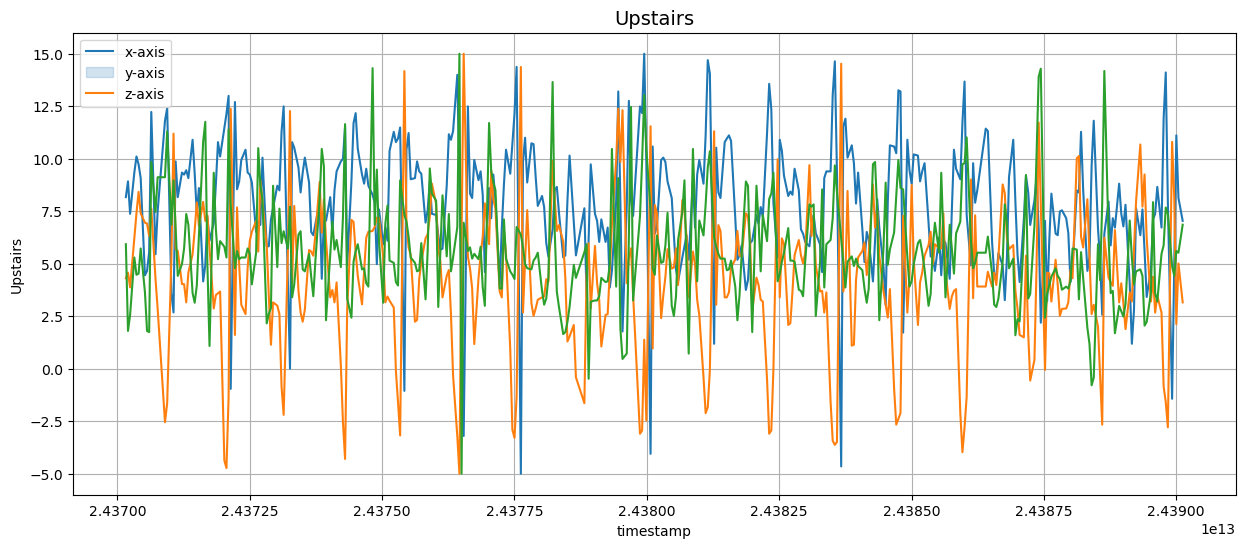

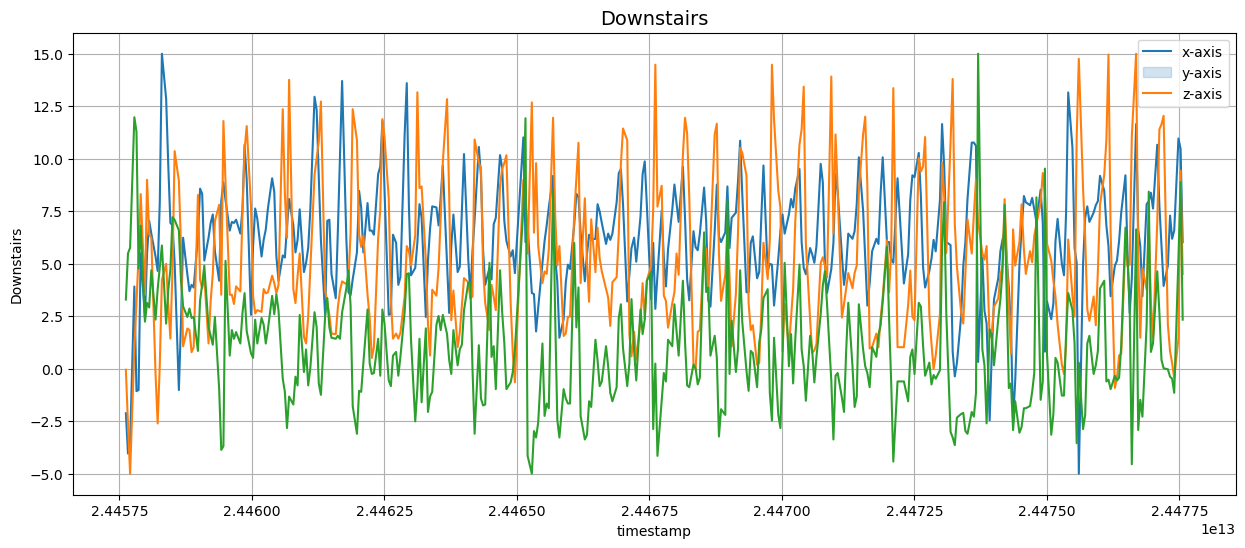

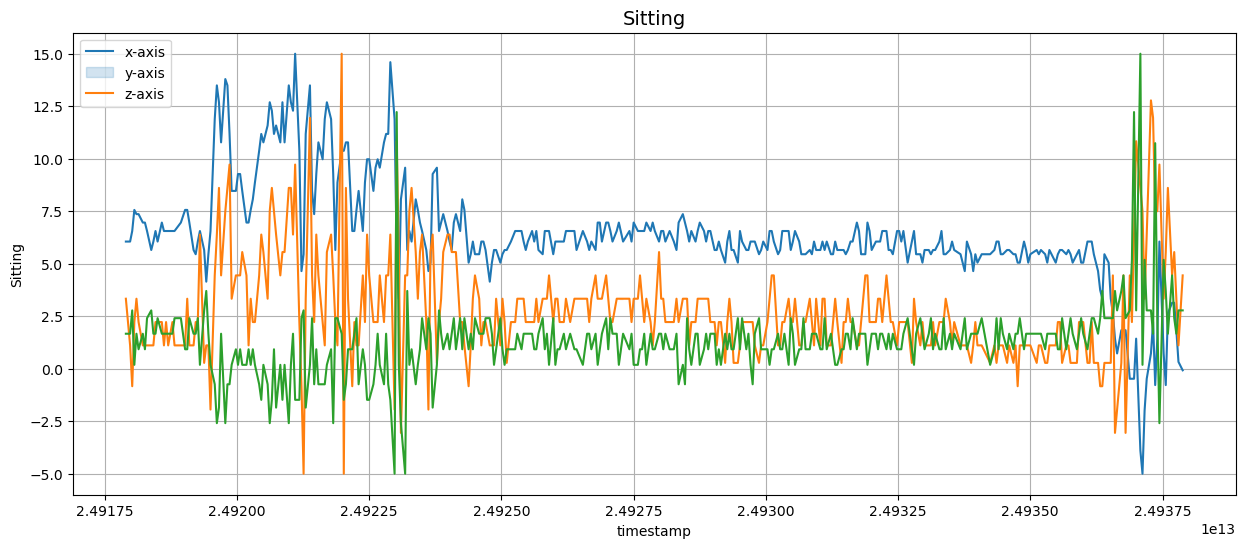

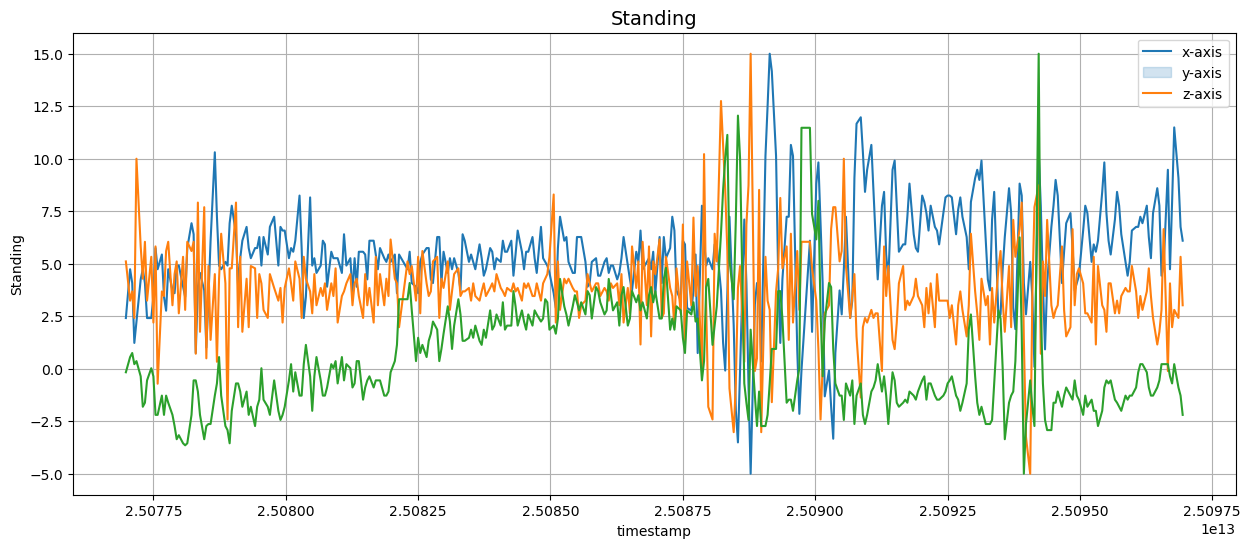

In [5]:
from sklearn.preprocessing import MinMaxScaler
# Initialize the scaler
scaler = MinMaxScaler(feature_range=(-5,15))

for i in ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']: 
    plt.figure(figsize=(15, 6))
    # User 31's data only 400 data points limit
    data_31 = df[(df['user'] == 31) & (df['activity'] == i)][:400]
    data_31[['x-axis', 'y-axis', 'z-axis']] = scaler.fit_transform(data_31[['x-axis', 'y-axis', 'z-axis']])
    sns.lineplot(y='x-axis', x='timestamp', data=data_31)
    sns.lineplot(y='y-axis', x='timestamp', data=data_31)
    sns.lineplot(y='z-axis', x='timestamp', data=data_31)
    plt.legend(['x-axis', 'y-axis', 'z-axis'])
    plt.ylabel(i)
    plt.grid(True)
    plt.title(i, fontsize=14, fontweight=14)
    plt.show()

In [7]:
# Convert the feature information for int to floats:
df['x-axis'] = df['x-axis'].astype(float)
df['y-axis'] = df['y-axis'].astype(float)
df['z-axis'] = df['z-axis'].astype(float)

In [8]:
# Remove the user and timestamp columns from the data frame
df = df.drop(['user','timestamp'], axis=1)

### Balance the Data

To balance the data we will isolate the data points so that all classes are equally represented. <br> The class with the lowest count is `standing` with a count of `48394` therefore I will noramlise all other data points to this value

In [9]:
df['activity'].value_counts()

activity
Walking       418393
Jogging       336445
Upstairs      122869
Downstairs    100425
Sitting        59939
Standing       48394
Name: count, dtype: int64

In [10]:
# Extract 48000 data points from all activity points: 
Walking = df[df['activity'] == 'Walking'].head(4800)
Jogging = df[df['activity'] == 'Jogging'].head(4800)
Upstairs = df[df['activity'] == 'Upstairs'].head(4800)
Downstairs = df[df['activity'] == 'Downstairs'].head(4800)
Sitting = df[df['activity'] == 'Sitting'].head(4800)
Standing = df[df['activity'] == 'Standing'].head(4800)

In [11]:
# Create a new balanced data frame: 
balanced_dataframe = pd.DataFrame()
balanced_dataframe = pd.concat([Walking, Jogging, Upstairs, Downstairs, Sitting, Standing])

In [12]:
balanced_dataframe.to_csv('processed_accelerometer_data.csv', index=False)

In [13]:
# Encode the activity label
label = LabelEncoder()
balanced_dataframe['label'] = label.fit_transform(balanced_dataframe['activity'])

### Standardise the features

In [14]:

X = balanced_dataframe[['x-axis', 'y-axis', 'z-axis']]
y = balanced_dataframe['label']

In [15]:
label.classes_

array(['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
       'Walking'], dtype=object)

In [16]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data=X, columns=['x-axis', 'y-axis', 'z-axis'])
scaled_X['label'] = y.values


In [17]:
scaled_X.shape

(28800, 4)

### Create Window 



Divide the data into small chunks of overlapping data points 

In [18]:
def get_windows(df, window_size, step_size):
    

    windows = []
    labels = []
    num_features = 3
    for i in range(0, len(df) - window_size, step_size):
        xs = df['x-axis'].values[i: i + window_size]
        ys = df['y-axis'].values[i: i + window_size]
        zs = df['z-axis'].values[i: i + window_size]
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df['label'][i: i + window_size])[0]
        windows.append([xs, ys, zs])
        labels.append(label)
        
    windows = np.asarray(windows).reshape(-1, window_size, num_features)
    labels = np.asarray(labels)
    
    return windows, labels
        

In [35]:
x, y = get_windows(scaled_X, 10, 5)

In [ ]:
x.shape, y.shape

((5758, 10, 3), (5758,))

In [37]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0, stratify=y)

In [38]:
X_train.shape , X_test.shape

((4606, 10, 3), (1152, 10, 3))

In [39]:
y_train.shape, y_test.shape

((4606,), (1152,))

In [41]:
X_train = X_train.reshape(-1, 10, 3, 1)  # Replace `10` and `3` with actual values
X_test = X_test.reshape(-1, 10, 3, 1)   # Ensure the same reshaping logic

## 2D CNN MODEL

In [42]:
model = Sequential()
model.add(Convolution2D(16, (2,2), activation= 'relu', input_shape = X_train[0].shape))
model.add(Dropout(0.1))

model.add(Convolution2D(32, (2,2), activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation= 'relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))



/opt/anaconda3/envs/ml-project-tf_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
model.compile(optimizer=Adam(learning_rate=0.001), loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [44]:

history = model.fit(X_train, y_train, epochs = 10, validation_data= (X_test, y_test), verbose= 1)


Epoch 1/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3399 - loss: 1.5709 - val_accuracy: 0.7543 - val_loss: 0.8213
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7048 - loss: 0.8275 - val_accuracy: 0.8238 - val_loss: 0.4732
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7905 - loss: 0.5796 - val_accuracy: 0.8359 - val_loss: 0.4070
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8084 - loss: 0.4871 - val_accuracy: 0.8655 - val_loss: 0.3551
Epoch 5/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8397 - loss: 0.4342 - val_accuracy: 0.8767 - val_loss: 0.3274
Epoch 6/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8491 - loss: 0.3955 - val_accuracy: 0.8793 - val_loss: 0.3250
Epoch 7/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8651 - loss: 0.3620 - val_accuracy: 0.8793 - val_loss: 0.3230
Epoch 8/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8781 - loss: 0.3718 - val_accuracy: 0.

`Observation`: There is slight overfitting of our model as after the 8 Epoch the validation accuracy is *greater* then the model accuracy indicating overfitting

### Learning Curve

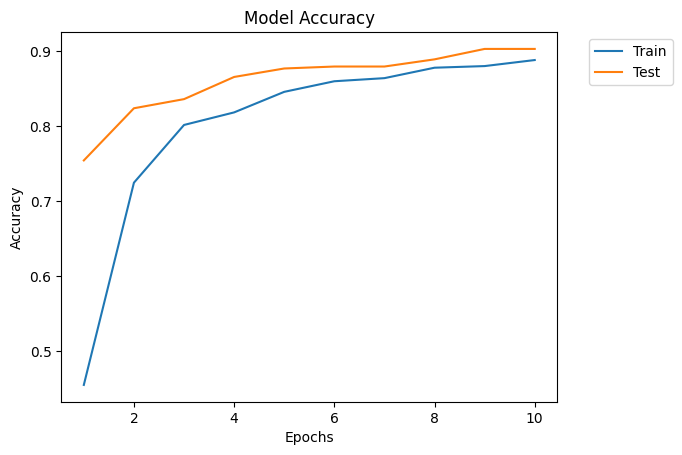

In [45]:
# Plot training and validataion accuracy values
epoch_range = range(1, 11)
plt.plot(epoch_range, history.history['accuracy'])
plt.plot(epoch_range, history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'], bbox_to_anchor=(1.05, 1))
plt.show()

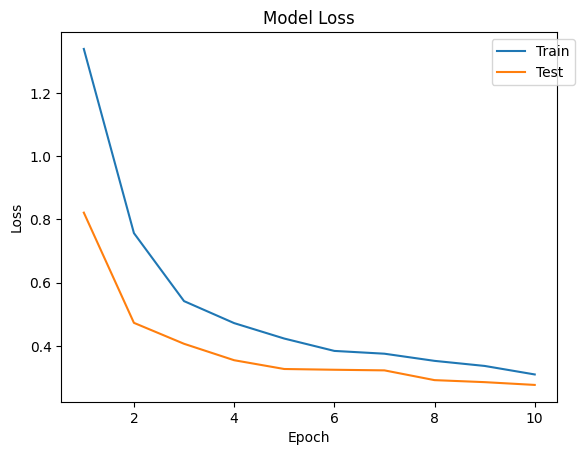

In [46]:
# Plot of training and validation loss:
plt.plot(epoch_range, history.history['loss'])
plt.plot(epoch_range, history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Test'], bbox_to_anchor=(1.05, 1))
plt.show()

## Confusion Matrix

In [47]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [48]:
y_pred = np.argmax(model.predict(X_test), axis=-1)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step


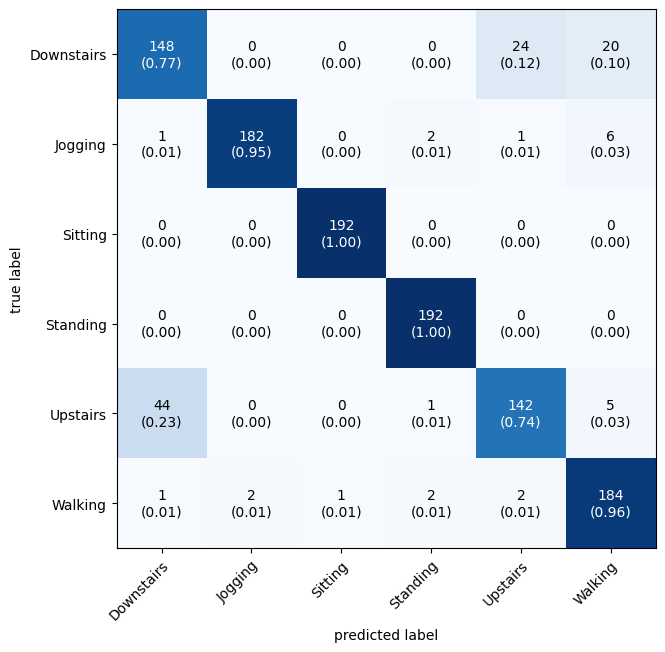

In [49]:
matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=matrix, class_names=label.classes_, show_normed=True, figsize=(7,7))
plt.show()

### Save Model

In [200]:
import pickle

In [201]:
filename = 'CNN_HAR_model.sav'
pickle.dump(model, open(filename, 'wb'))